In [390]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from bokeh.plotting import figure, show

In [391]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [392]:
from clickhouse_driver import Client as Clickhouse
from uuid import uuid4
from pathlib import Path

def click_query(q, params=None):
    click = Clickhouse("localhost")
    return click.query_dataframe(q, params=params)

def click_query_fsn(q, params=None):
    click = Clickhouse("backend-fsn.ooni.org")
    return click.query_dataframe(q, params=params)

In [393]:
def get_explorer_url(e):
    return f'https://explorer.ooni.org/m/{e['measurement_uid']}'
def print_explorer_url(e):
    print(get_explorer_url(e))

# Plot measurements with inconsistent timestamps

We want the following plots: 
- Make a plot or table for measurements from the future and the past
- One for all probes
- One per platform
- By country


Base query required to pull this data: 
```
WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
SELECT
    countIf(time_diff > 3600) AS cnt_past_gt_1h,
    countIf(time_diff > 86400) AS cnt_past_gt_24h,
    countIf(time_diff > 604800) AS cnt_past_gt_7d,
    countIf(time_diff < -3600) AS cnt_future_gt_1h,
    countIf(time_diff < -86400) AS cnt_future_gt_24h,
    countIf(time_diff < -604800) AS cnt_future_gt_7d,
    COUNT(*) AS cnt
FROM fastpath
WHERE measurement_start_time >= now() - INTERVAL 30 DAY
AND measurement_start_time < now()



```

## Total anomalies for the last 30 days 

In [394]:
query = """
WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
SELECT
    countIf(time_diff > 3600) AS cnt_past_gt_1h,
    countIf(time_diff > 86400) AS cnt_past_gt_24h,
    countIf(time_diff > 604800) AS cnt_past_gt_7d,
    countIf(time_diff < -3600) AS cnt_future_gt_1h,
    countIf(time_diff < -86400) AS cnt_future_gt_24h,
    countIf(time_diff < -604800) AS cnt_future_gt_7d,
    cnt_past_gt_1h + cnt_future_gt_1h as cnt_anomalies,
    COUNT(*) AS cnt,
    (cnt_anomalies / cnt) * 100 as anomaly_percent 
FROM fastpath
WHERE measurement_start_time >= now() - INTERVAL 30 DAY
AND measurement_start_time < now() - INTERVAL 1 DAY
"""

click_query_fsn(query)

,cnt_past_gt_1h,cnt_past_gt_24h,cnt_past_gt_7d,cnt_future_gt_1h,cnt_future_gt_24h,cnt_future_gt_7d,cnt_anomalies,cnt,anomaly_percent
0,246971,76871,405,33933,513,0,280904,35558786,0.789971


In [395]:
from datetime import timedelta, date
now = date.today() - timedelta(days=1)
a_month_ago = now - timedelta(days=30)
print(f"From {a_month_ago} to {now}")

From 2025-03-08 to 2025-04-07


- There are not many measurements from the future, and most of them are concentrated in the 1-hour-difference bucket
- There are more measurements from the past that from the future (which is expected)
- The more significant variants are:
    - 1h-past
    - 24h-past
    - 1h-future
    - Nor in the past of the future we have anomalies with more than 7 days of difference

## Distribution of measurements with problems for the last 30 days 
### Measurements from the past


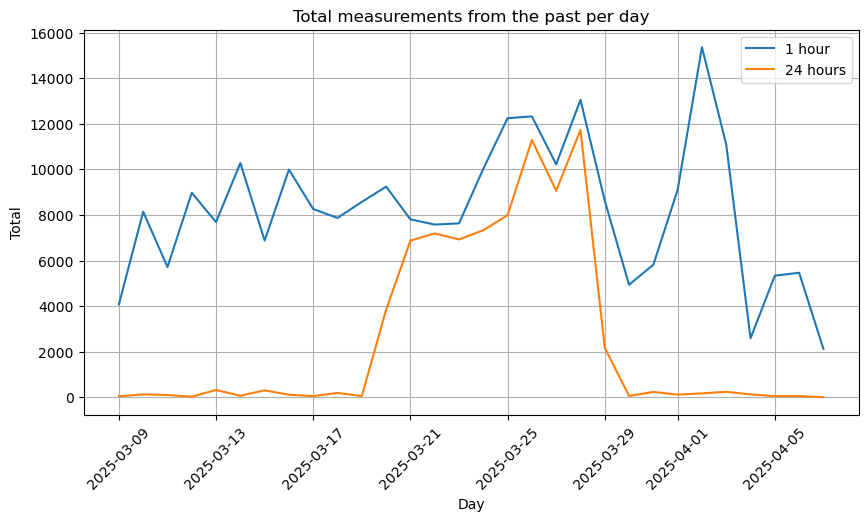

In [396]:
df_10days = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        day,
        countIf(time_diff > 3600) AS "cnt_past_1h",
        countIf(time_diff > 86400) AS "cnt_past_24h"
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY
    AND measurement_start_time < now() - INTERVAL 1 DAY
    group by day 
    order by day asc
    """
)
df_10days["day"] = pd.to_datetime(df_10days["day"])
df_10days.rename(columns={"cnt_past_1h" : "1 hour", "cnt_past_24h" : "24 hours"}, inplace=True)
# Plot
plt.figure(figsize=(10, 5))
for column in df_10days.columns[1:]:  # Skip the 'day' column
    plt.plot(df_10days["day"], df_10days[column], label=column)

# Formatting
plt.xlabel("Day")
plt.ylabel("Total")
plt.title("Total measurements from the past per day")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("./figures/msmnts_past_last_30_days.png", dpi=300, bbox_inches="tight")
# Show plot
plt.show()

There is a strange spike between 2025-03-17 and 2025-03-29

### Measurements from the future

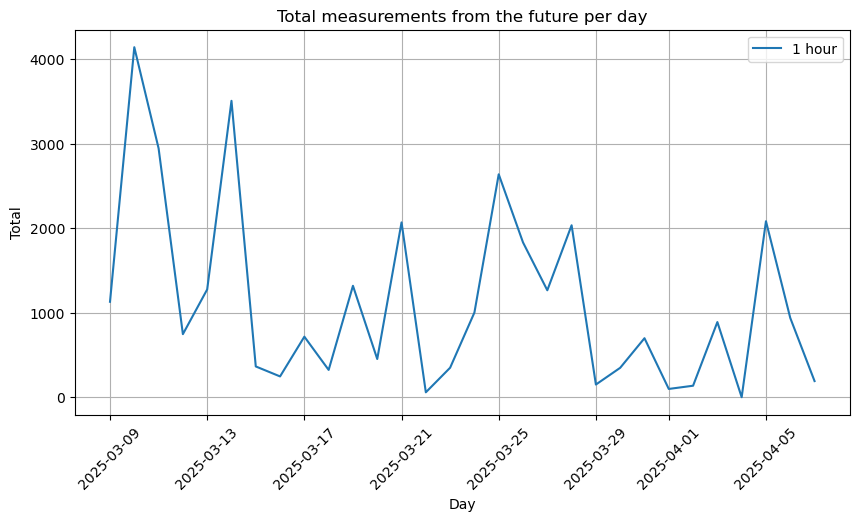

In [397]:
df_10days = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        day,
        countIf(time_diff < -3600) AS cnt_future_gt_1h
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY
    AND measurement_start_time < now() - INTERVAL 1 DAY
    group by day 
    order by day asc
    """
)
df_10days["day"] = pd.to_datetime(df_10days["day"])
df_10days.rename(columns={"cnt_future_gt_1h" : "1 hour"}, inplace=True)

# Plot
plt.figure(figsize=(10, 5))
for column in df_10days.columns[1:]:  # Skip the 'day' column
    plt.plot(df_10days["day"], df_10days[column], label=column)

# Formatting
plt.xlabel("Day")
plt.ylabel("Total")
plt.title("Total measurements from the future per day")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.savefig("./figures/msmnts_future_last_30_days.png", dpi=300, bbox_inches="tight")
plt.show()

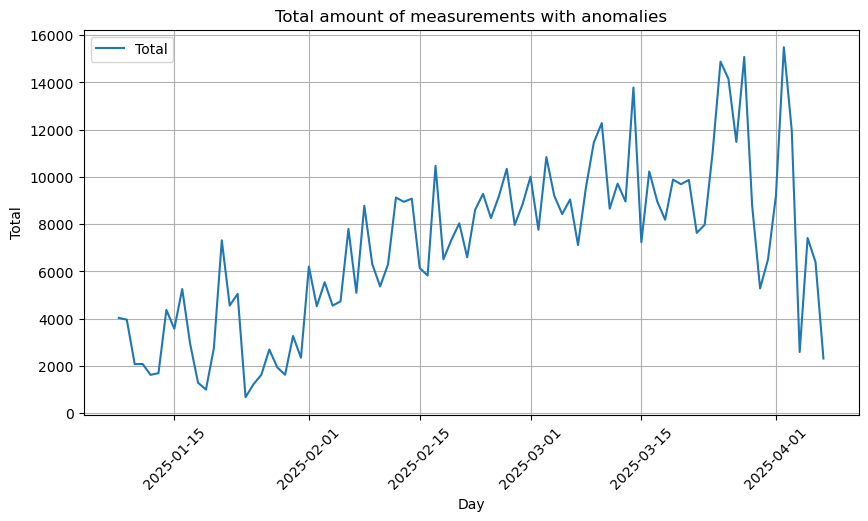

In [398]:
df_10days = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        day,
        countIf(time_diff < -3600) + countIf(time_diff > 3600) as total_anomalies
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 90 DAY
    AND measurement_start_time < now() - INTERVAL 1 DAY
    group by day 
    order by day asc
    """
)
df_10days["day"] = pd.to_datetime(df_10days["day"])
df_10days.rename(columns={"total_anomalies" : "Total"}, inplace=True)

# Plot
plt.figure(figsize=(10, 5))
for column in df_10days.columns[1:]:  # Skip the 'day' column
    plt.plot(df_10days["day"], df_10days[column], label=column)

# Formatting
plt.xlabel("Day")
plt.ylabel("Total")
plt.title("Total amount of measurements with anomalies")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.show()

## Distribution per platform

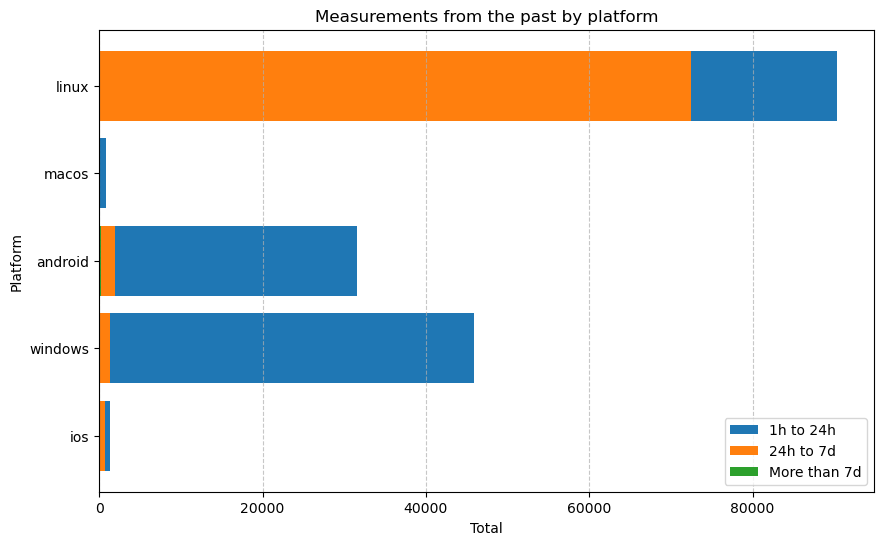

In [403]:
platform_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        platform,
        countIf(time_diff > 3600 and time_diff < 3600 * 24) AS cnt_past_gt_1h,
        countIf(time_diff > 3600 * 24 and time_diff < 3600 * 24 * 7 ) AS cnt_past_gt_24h,
        countIf(time_diff > 3600 * 24 * 7 ) AS cnt_past_gt_7d,
        countIf(time_diff < -3600 and time_diff > - 3600 * 24) AS cnt_future_gt_1h,
        countIf(time_diff < - 3600 * 24 and time_diff > - 3600 * 24 * 7 ) AS cnt_future_gt_24h,
        countIf(time_diff < - 3600 * 24 * 7 ) AS cnt_future_gt_7d,
        cnt_past_gt_1h + cnt_future_gt_1h as cnt_anomaly,
        (cnt_anomaly / cnt) * 100 as anomaly_percent,
        count(*) as cnt
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY and platform <> 'freebsd' and platform <> 'unset' and platform <> 'unknown' and platform <> 'React OS'
    AND measurement_start_time < now() - INTERVAL 1 DAY
    group by platform 
    """
)

platform_df.drop(columns=['cnt'])

# Define bar width
bar_width = 0.6
platforms = platform_df["platform"]

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
ax.barh(platforms, platform_df["cnt_past_gt_1h"], label="1h to 24h")
ax.barh(platforms, platform_df["cnt_past_gt_24h"], label="24h to 7d")
ax.barh(platforms, platform_df["cnt_past_gt_7d"], label="More than 7d")
# ax.barh(platforms, platform_df["cnt_future_gt_1h"], label="Future > 1h", left=platform_df["cnt_past_gt_1h"])

# Labels and title
ax.set_xlabel("Total")
ax.set_ylabel("Platform")
ax.set_title("Measurements from the past by platform")
ax.legend()

# Show grid and plot
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("./figures/count_anomalies_per_platform_past.png")
plt.show()

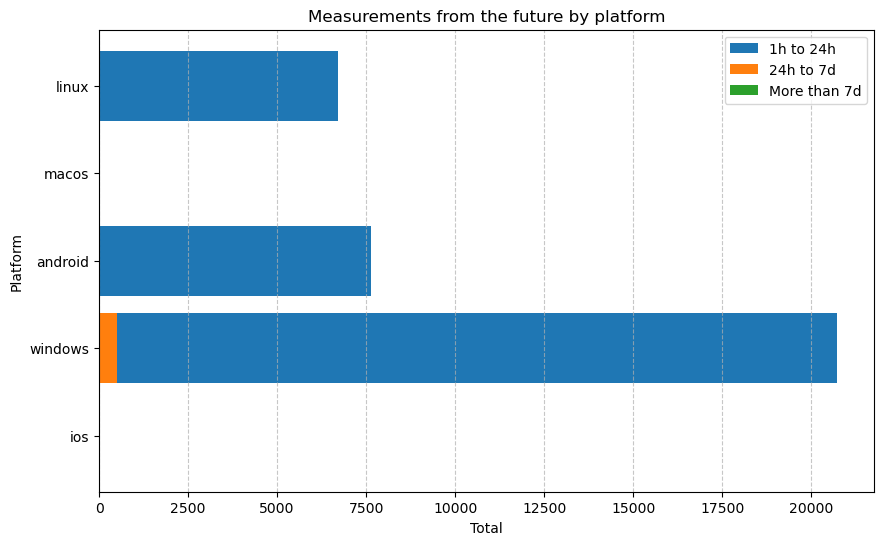

In [332]:
# Define bar width
bar_width = 0.6
platforms = platform_df["platform"]

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
ax.barh(platforms, platform_df["cnt_future_gt_1h"], label="1h to 24h")
ax.barh(platforms, platform_df["cnt_future_gt_24h"], label="24h to 7d")
ax.barh(platforms, platform_df["cnt_future_gt_7d"], label="More than 7d")
# ax.barh(platforms, platform_df["cnt_future_gt_1h"], label="Future > 1h", left=platform_df["cnt_past_gt_1h"])

# Labels and title
ax.set_xlabel("Total")
ax.set_ylabel("Platform")
ax.set_title("Measurements from the future by platform")
ax.legend()

# Show grid and plot
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("./figures/count_anomalies_per_platform_future.png")
plt.show()

In [333]:
platform_df

,platform,cnt_past_gt_1h,cnt_past_gt_24h,cnt_past_gt_7d,cnt_future_gt_1h,cnt_future_gt_24h,cnt_future_gt_7d,cnt_anomaly,anomaly_percent,cnt
0,ios,1346,743,84,0,0,0,1346,0.537815,250272
1,windows,43796,1285,2,20733,492,0,64529,0.623462,10350109
2,android,28279,2073,221,7648,21,0,35927,0.316067,11366883
3,macos,838,2,63,0,0,0,838,0.027216,3079048
4,linux,97192,72477,22,6703,0,0,103895,1.147162,9056698


I notice that most of the issues come from linux, I'm curious about the software name and the architecture 

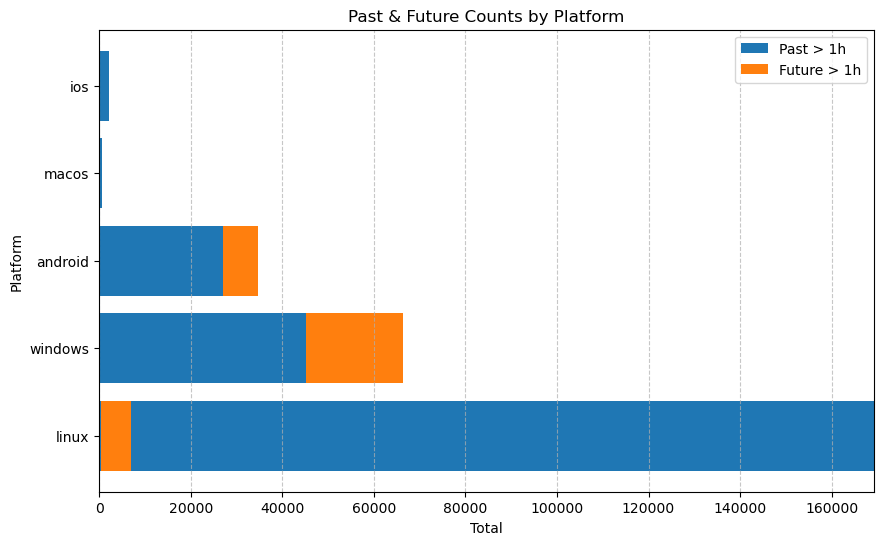

In [334]:
platform_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        platform,
        architecture, 
        countIf(time_diff > 3600) AS cnt_past_gt_1h,
        countIf(time_diff < -3600) AS cnt_future_gt_1h,
        cnt_past_gt_1h + cnt_future_gt_1h as cnt_anomaly,
        (cnt_anomaly / cnt) * 100 as anomaly_percent,
        count(*) as cnt,
        concat(platform, ' - ', architecture) as arch_plat
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY and platform <> 'freebsd' and platform <> 'unset' and platform <> 'unknown' and platform <> 'React OS'
    AND measurement_start_time < now() - INTERVAL 1 DAY
    group by platform, architecture 
    """
)

platform_df.drop(columns=['cnt', 'architecture', 'platform'])
platform_df

# Define bar width
bar_width = 0.6
platforms = platform_df["platform"]

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
ax.barh(platforms, platform_df["cnt_past_gt_1h"], label="Past > 1h")
ax.barh(platforms, platform_df["cnt_future_gt_1h"], label="Future > 1h",
        left=platform_df["cnt_past_gt_1h"])

# Labels and title
ax.set_xlabel("Total")
ax.set_ylabel("Platform")
ax.set_title("Past & Future Counts by Platform")
ax.legend()

# Show grid and plot
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("./figures/count_anomalies_per_platform.png")
plt.show()

Venezuela is the most prominent user of our linux distributions, so it's possible that a lot of these measurements come from there. Let's take a look without Venezuelan measurements
### Without Venezuela

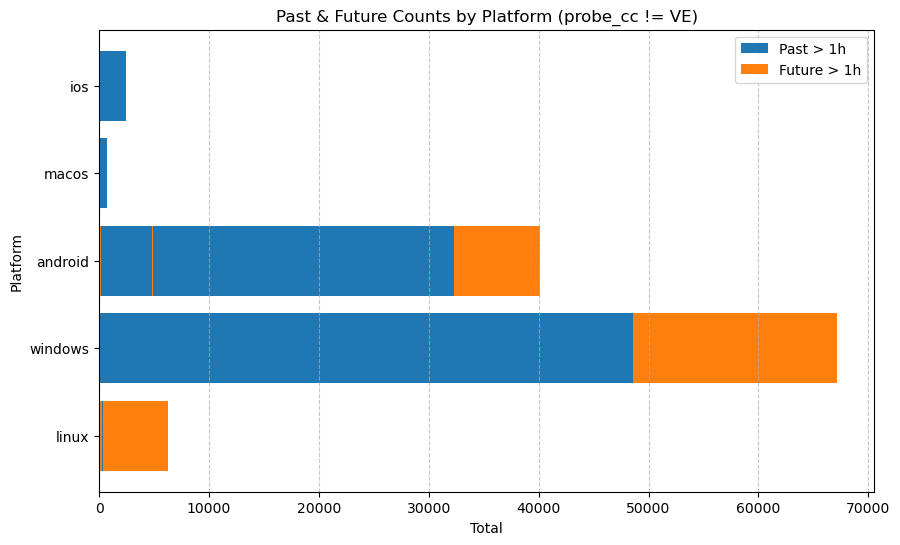

In [455]:
platform_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        platform,
        architecture, 
        countIf(time_diff > 3600) AS cnt_past_gt_1h,
        countIf(time_diff < -3600) AS cnt_future_gt_1h,
        cnt_past_gt_1h + cnt_future_gt_1h as cnt_anomaly,
        (cnt_anomaly / cnt) * 100 as anomaly_percent,
        count(*) as cnt,
        concat(platform, ' - ', architecture) as arch_plat
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY and platform <> 'freebsd' and platform <> 'unset' and platform <> 'unknown' and platform <> 'React OS' and probe_cc <> 'VE'
    AND measurement_start_time < now() - INTERVAL 1 DAY
    group by platform, architecture 
    """
)

platform_df.drop(columns=['cnt', 'architecture', 'platform'])
platform_df

# Define bar width
bar_width = 0.6
platforms = platform_df["platform"]

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
ax.barh(platforms, platform_df["cnt_past_gt_1h"], label="Past > 1h")
ax.barh(platforms, platform_df["cnt_future_gt_1h"], label="Future > 1h",
        left=platform_df["cnt_past_gt_1h"])

# Labels and title
ax.set_xlabel("Total")
ax.set_ylabel("Platform")
ax.set_title("Past & Future Counts by Platform (probe_cc != VE)")
ax.legend()

# Show grid and plot
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("./figures/count_anomalies_per_platform_no_ve.png")
plt.show()

Similar as before but we now see that there are barely no measurements from the past in linux. Not many measurements in general from Linux

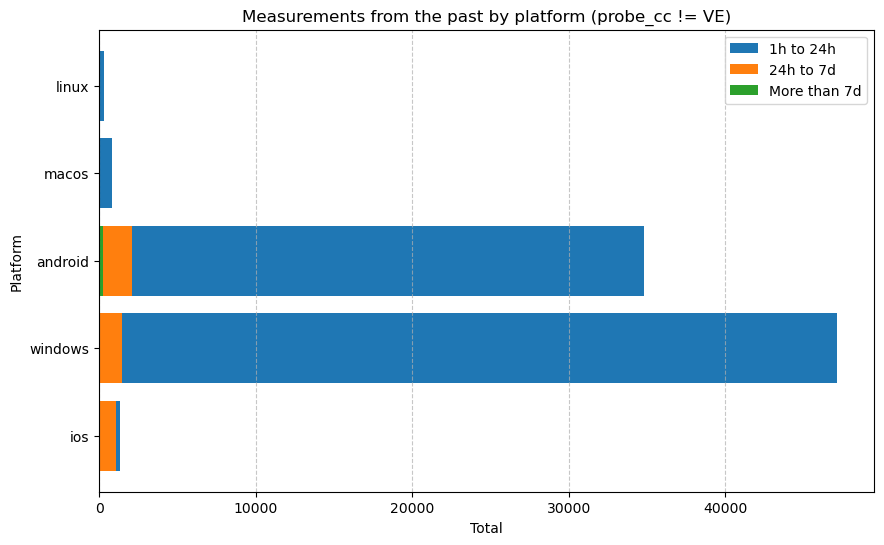

In [456]:
platform_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        platform,
        countIf(time_diff > 3600 and time_diff < 3600 * 24) AS cnt_past_gt_1h,
        countIf(time_diff > 3600 * 24 and time_diff < 3600 * 24 * 7 ) AS cnt_past_gt_24h,
        countIf(time_diff > 3600 * 24 * 7 ) AS cnt_past_gt_7d,
        countIf(time_diff < -3600 and time_diff > - 3600 * 24) AS cnt_future_gt_1h,
        countIf(time_diff < - 3600 * 24 and time_diff > - 3600 * 24 * 7 ) AS cnt_future_gt_24h,
        countIf(time_diff < - 3600 * 24 * 7 ) AS cnt_future_gt_7d,
        cnt_past_gt_1h + cnt_future_gt_1h as cnt_anomaly,
        (cnt_anomaly / cnt) * 100 as anomaly_percent,
        count(*) as cnt
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY and platform <> 'freebsd' and platform <> 'unset' and platform <> 'unknown' and platform <> 'React OS' and probe_cc <> 'VE'
    AND measurement_start_time < now() - INTERVAL 1 DAY
    group by platform 
    """
)

platform_df.drop(columns=['cnt'])

# Define bar width
bar_width = 0.6
platforms = platform_df["platform"]

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
ax.barh(platforms, platform_df["cnt_past_gt_1h"], label="1h to 24h")
ax.barh(platforms, platform_df["cnt_past_gt_24h"], label="24h to 7d")
ax.barh(platforms, platform_df["cnt_past_gt_7d"], label="More than 7d")
# ax.barh(platforms, platform_df["cnt_future_gt_1h"], label="Future > 1h", left=platform_df["cnt_past_gt_1h"])

# Labels and title
ax.set_xlabel("Total")
ax.set_ylabel("Platform")
ax.set_title("Measurements from the past by platform (probe_cc != VE)")
ax.legend()

# Show grid and plot
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("./figures/count_anomalies_per_platform_past_no_ve.png")
plt.show()

## Grouped by country

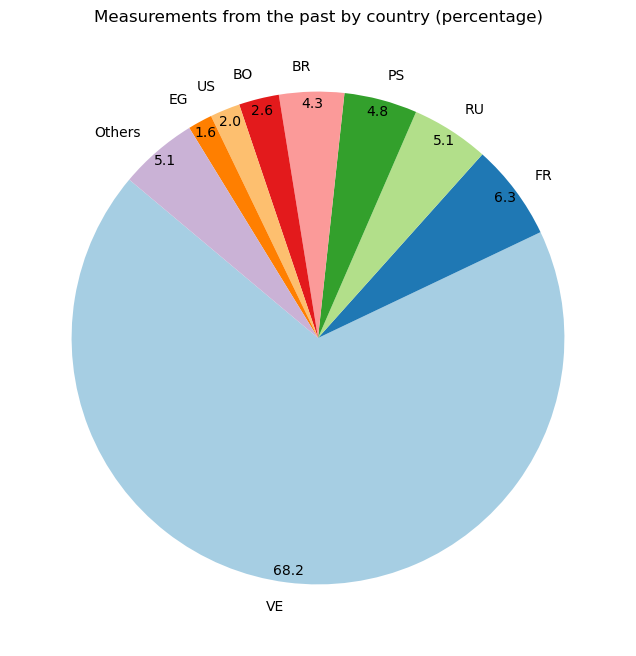

In [335]:
country_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        probe_cc,
        countIf(time_diff > 3600) AS cnt_past_gt_1h,
        countIf(time_diff < -3600) AS cnt_future_gt_1h,
        cnt_past_gt_1h as cnt_anomaly,
        (cnt_anomaly / cnt) * 100 as anomaly_percent,
        count(*) as cnt
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY and platform <> 'freebsd' and platform <> 'unset' and platform <> 'unknown' and platform <> 'React OS'
    AND measurement_start_time < now() - INTERVAL 1 DAY 
    group by probe_cc 
    order by cnt_anomaly desc
    """
)

# country_df.drop(columns=['cnt'])
total_by_cc = country_df[['cnt_anomaly', 'probe_cc']].copy()
CUTOUT = 2500
others = total_by_cc[total_by_cc['cnt_anomaly'] < CUTOUT]
total_by_cc = total_by_cc[total_by_cc['cnt_anomaly'] > CUTOUT]
others = pd.DataFrame({"probe_cc" : ['Others'], "cnt_anomaly" : others['cnt_anomaly'].sum()})
total_by_cc = pd.concat([total_by_cc, others], ignore_index=True)
total_by_cc

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    total_by_cc["cnt_anomaly"], 
    labels=total_by_cc["probe_cc"], 
    autopct="%1.1f",  # Show percentages
    startangle=140,  # Rotate for better view
    colors=plt.cm.Paired.colors,  # Use a colormap for colors
    pctdistance=0.95
)

# Add title
plt.title("Measurements from the past by country (percentage)")
plt.savefig("figures/anomalies_per_country_past.png")
plt.show()


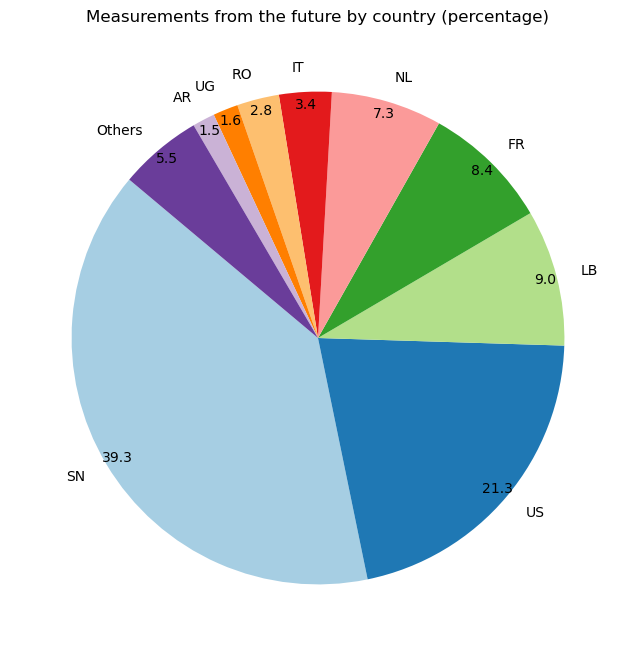

In [336]:
country_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        probe_cc,
        countIf(time_diff > 3600) AS cnt_past_gt_1h,
        countIf(time_diff < -3600) AS cnt_future_gt_1h,
        cnt_future_gt_1h as cnt_anomaly,
        (cnt_anomaly / cnt) * 100 as anomaly_percent,
        count(*) as cnt
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY and platform <> 'freebsd' and platform <> 'unset' and platform <> 'unknown' and platform <> 'React OS'
    AND measurement_start_time < now() - INTERVAL 1 DAY 
    group by probe_cc 
    order by cnt_anomaly desc
    """
)

# country_df.drop(columns=['cnt'])
total_by_cc = country_df[['cnt_anomaly', 'probe_cc']].copy()
CUTOUT = 500
others = total_by_cc[total_by_cc['cnt_anomaly'] < CUTOUT]
total_by_cc = total_by_cc[total_by_cc['cnt_anomaly'] > CUTOUT]
others = pd.DataFrame({"probe_cc" : ['Others'], "cnt_anomaly" : others['cnt_anomaly'].sum()})
total_by_cc = pd.concat([total_by_cc, others], ignore_index=True)
total_by_cc

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    total_by_cc["cnt_anomaly"], 
    labels=total_by_cc["probe_cc"], 
    autopct="%1.1f",  # Show percentages
    startangle=140,  # Rotate for better view
    colors=plt.cm.Paired.colors,  # Use a colormap for colors
    pctdistance=0.95
)

# Add title
plt.title("Measurements from the future by country (percentage)")
plt.savefig("figures/anomalies_per_country_future.png")
plt.show()


# ECDF Chart


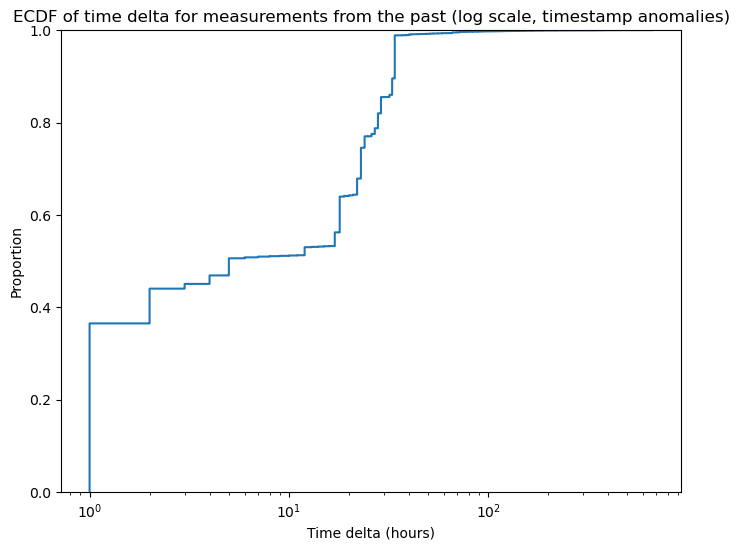

In [441]:
deltas = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('hour', measurement_start_time, uid_ts) AS time_diff
    SELECT
        time_diff 
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY
    AND measurement_start_time < now() - INTERVAL 1 DAY
    AND (time_diff >= 1) 
    order by time_diff
    """
)
deltas
plt.figure(figsize=(8, 6))
sns.ecdfplot(deltas["time_diff"], log_scale=True)

# Add title
plt.title("ECDF of time delta for measurements from the past (log scale, timestamp anomalies)")
plt.xlabel("Time delta (hours)")

# Save the plot to a file (e.g., PNG)
plt.savefig("figures/time_delta_ecdf_past.png", dpi=300)  # You can change the file name and format here

# Optionally, display the plot
plt.show()

<Axes: ylabel='Count'>

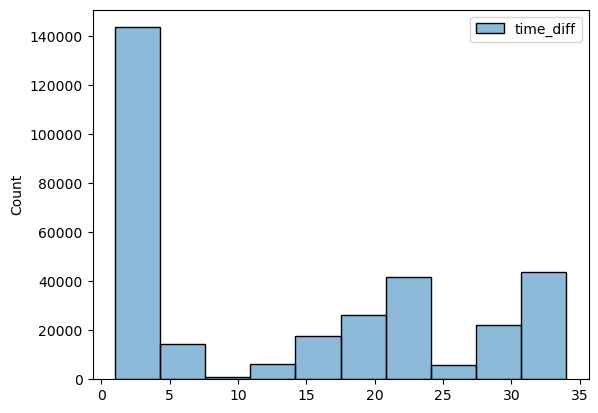

In [338]:
sns.histplot(deltas[deltas['time_diff'] < 35], bins=10)

In [339]:
len(deltas[deltas['time_diff'] < 35])

322002

<Axes: ylabel='Count'>

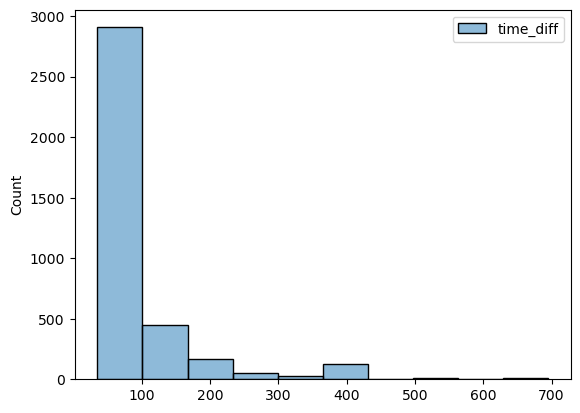

In [340]:
sns.histplot(deltas[deltas['time_diff'] >= 35], bins=10)

In [341]:
len(deltas[deltas['time_diff'] >= 35])

3763

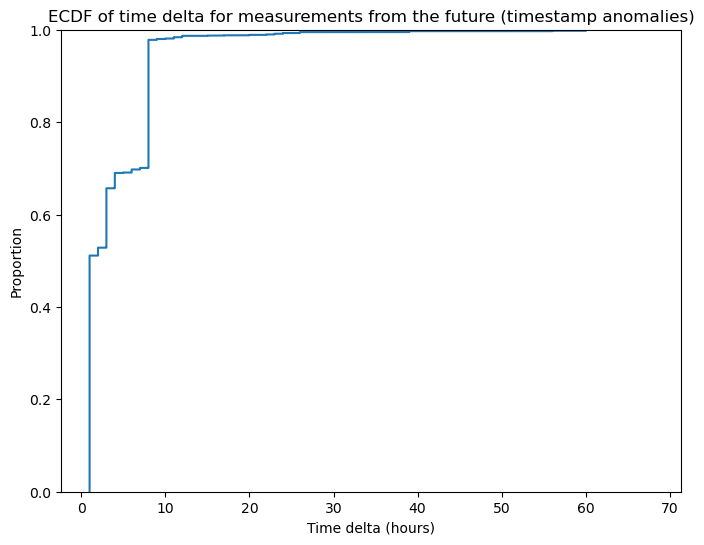

In [440]:
deltas = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('hour', measurement_start_time, uid_ts) AS time_diff
    SELECT
        time_diff
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY
    AND measurement_start_time < now() - INTERVAL 1 DAY
    AND (time_diff <= -1) 
    order by time_diff
    """
)
deltas
deltas['time_diff'] = -deltas['time_diff']
plt.figure(figsize=(8, 6))
sns.ecdfplot(deltas["time_diff"])

# Add title
plt.title("ECDF of time delta for measurements from the future (timestamp anomalies)")
plt.xlabel("Time delta (hours)")

# Save the plot to a file (e.g., PNG)
plt.savefig("figures/time_delta_ecdf_future.png", dpi=300)  # You can change the file name and format here

# Optionally, display the plot
plt.show()

So it seems that most time anomalies are concentrated within the 1 to 35 hours range, 

The following charts are useful as a reference for the average test_runtime of measurements in general, not only measurements with issues 

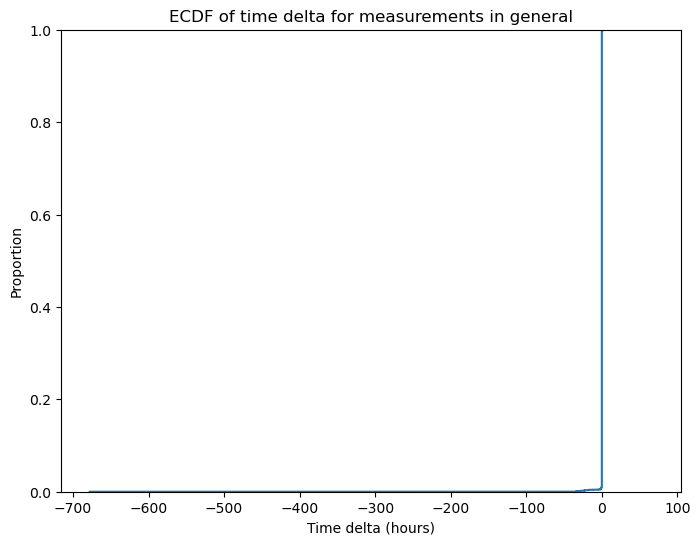

In [454]:
deltas = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('hour', measurement_start_time, uid_ts) AS time_diff
    SELECT
        time_diff
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY
    AND measurement_start_time < now() - INTERVAL 1 DAY
    order by time_diff
    """
)
deltas
deltas['time_diff'] = -deltas['time_diff']
plt.figure(figsize=(8, 6))
sns.ecdfplot(deltas["time_diff"], log_scale = False)

# Add title
plt.title("ECDF of time delta for measurements in general")
plt.xlabel("Time delta (hours)")

# Save the plot to a file (e.g., PNG)
plt.savefig("figures/time_delta_ecdf_all_no_issues.png", dpi=300)  # You can change the file name and format here

# Optionally, display the plot
plt.show()

# Check frequency by software name

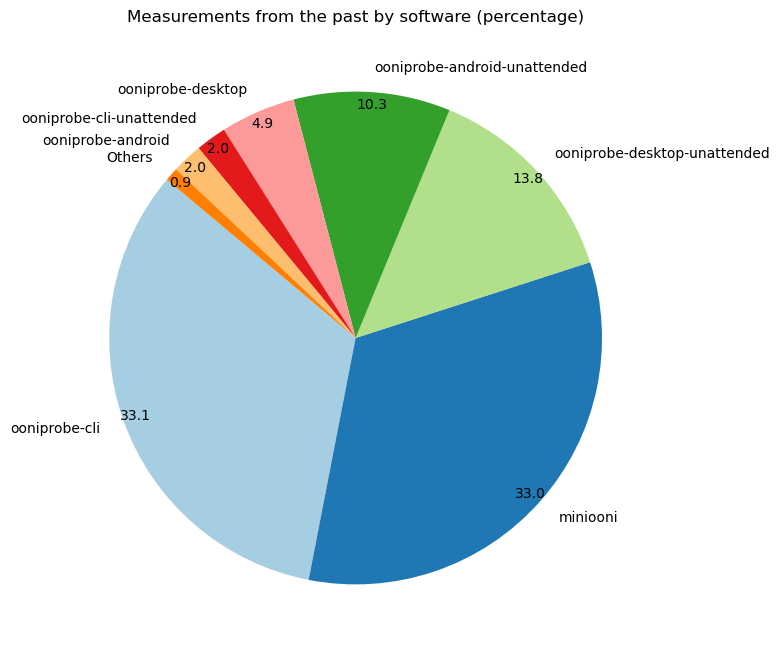

In [386]:
country_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        software_name,
        countIf(time_diff > 3600) AS cnt_past_gt_1h,
        countIf(time_diff < -3600) AS cnt_future_gt_1h,
        cnt_past_gt_1h as cnt_anomaly,
        (cnt_anomaly / cnt) * 100 as anomaly_percent,
        count(*) as cnt
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY and platform <> 'freebsd' and platform <> 'unset' and platform <> 'unknown' and platform <> 'React OS'
    AND measurement_start_time < now() - INTERVAL 1 DAY 
    group by software_name 
    order by cnt_anomaly desc
    """
)

# country_df.drop(columns=['cnt'])
total_by_cc = country_df[['cnt_anomaly', 'software_name']].copy()
CUTOUT = 2500
others = total_by_cc[total_by_cc['cnt_anomaly'] < CUTOUT]
total_by_cc = total_by_cc[total_by_cc['cnt_anomaly'] > CUTOUT]
others = pd.DataFrame({"software_name" : ['Others'], "cnt_anomaly" : others['cnt_anomaly'].sum()})
total_by_cc = pd.concat([total_by_cc, others], ignore_index=True)
total_by_cc

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    total_by_cc["cnt_anomaly"], 
    labels=total_by_cc["software_name"], 
    autopct="%1.1f",  # Show percentages
    startangle=140,  # Rotate for better view
    colors=plt.cm.Paired.colors,  # Use a colormap for colors
    pctdistance=0.95
)

# Add title
plt.title("Measurements from the past by software (percentage)")
plt.savefig("figures/anomalies_per_software_past.png")
plt.show()

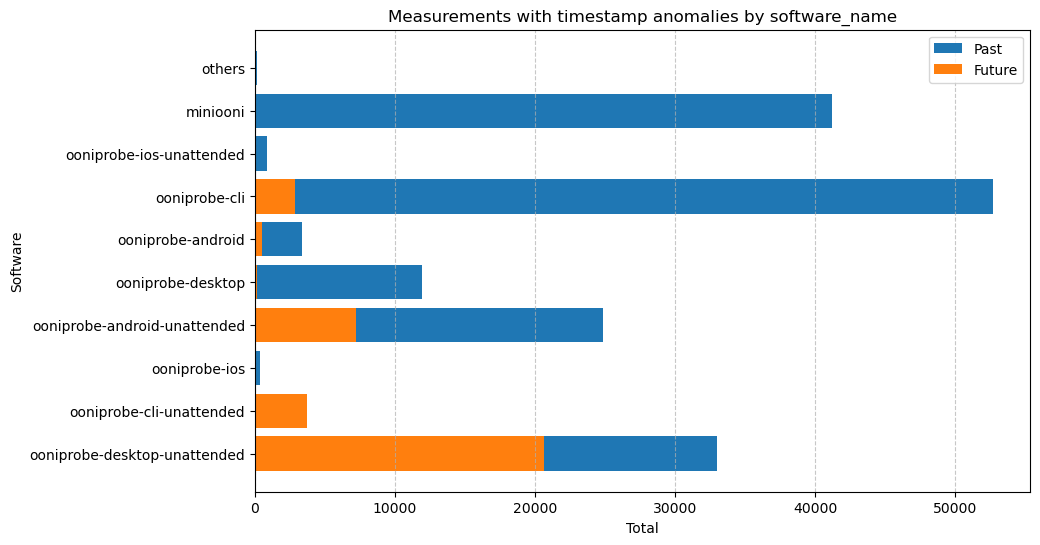

In [385]:
software_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('second', measurement_start_time, uid_ts) AS time_diff
    SELECT
        software_name,
        countIf(time_diff > 3600 and time_diff < 3600 * 24) AS cnt_past_gt_1h,
        countIf(time_diff < -3600 and time_diff > - 3600 * 24) AS cnt_future_gt_1h,
        cnt_past_gt_1h + cnt_future_gt_1h as cnt_anomaly,
        (cnt_anomaly / cnt) * 100 as anomaly_percent,
        count(*) as cnt
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY
    AND measurement_start_time < now() - INTERVAL 1 DAY
    group by software_name 
    """
)

CUTOUT = 250
others = software_df[software_df['cnt_anomaly'] < CUTOUT]
software_df = software_df[software_df['cnt_anomaly'] >= CUTOUT]

# Sum up stats for others
others['software_name'] = 'others'
others = others.groupby(['software_name']).sum()
software_df = pd.concat([software_df, others], ignore_index = True)
software_df.at[len(software_df) - 1, 'software_name'] = 'others'

# Define bar width
bar_width = 0.6
softwares = software_df["software_name"]

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
ax.barh(softwares, software_df["cnt_past_gt_1h"], label="Past")
ax.barh(softwares, software_df["cnt_future_gt_1h"], label="Future")
# ax.barh(platforms, platform_df["cnt_future_gt_1h"], label="Future > 1h", left=platform_df["cnt_past_gt_1h"])

# Labels and title
ax.set_xlabel("Total")
ax.set_ylabel("Software")
ax.set_title("Measurements with timestamp anomalies by software_name")
ax.legend()

# Show grid and plot
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.savefig("./figures/count_anomalies_per_software_name.png", bbox_inches='tight', pad_inches=0.3)
plt.show()

In [382]:
software_df

,software_name,cnt_past_gt_1h,cnt_future_gt_1h,cnt_anomaly,anomaly_percent,cnt
0,ooniprobe-desktop-unattended,33017.0,20601.0,53618.0,0.421149,12731353.0
1,ooniprobe-cli-unattended,3117.0,3728.0,6845.0,0.302439,2263268.0
2,ooniprobe-ios,380.0,0.0,380.0,0.463556,81975.0
3,ooniprobe-android-unattended,24856.0,7187.0,32043.0,0.299778,10688912.0
4,ooniprobe-desktop,11894.0,132.0,12026.0,3.295228,364952.0
5,ooniprobe-android,3376.0,490.0,3866.0,0.688448,561553.0
6,ooniprobe-cli,52707.0,2857.0,55564.0,1.489847,3729510.0
7,ooniprobe-ios-unattended,856.0,0.0,856.0,0.564004,151772.0
8,miniooni,41212.0,0.0,41212.0,1.186663,3472933.0
9,NaN,132.0,0.0,132.0,0.984821,1281723.0


In [380]:
others

,cnt_past_gt_1h,cnt_future_gt_1h,cnt_anomaly,anomaly_percent,cnt
software_name,,,,,
others,131,0,131,0.983983,1281737


# ECDF per platform

The stacked barchar above is not very useful, we will do an ECDF instead

In [434]:
timediff_platform_df = click_query_fsn(
    """
    WITH 
    toDate(measurement_start_time) AS day,
    toDateTime(
        concat(
            substring(measurement_uid, 1, 4), '-',
            substring(measurement_uid, 5, 2), '-',
            substring(measurement_uid, 7, 2), ' ',
            substring(measurement_uid, 9, 2), ':',
            substring(measurement_uid, 11, 2), ':',
            substring(measurement_uid, 13, 2)
        )
    ) AS uid_ts,
    dateDiff('hour', measurement_start_time, uid_ts) AS time_diff
    SELECT
        time_diff, 
        platform
    FROM fastpath
    WHERE measurement_start_time >= now() - INTERVAL 30 DAY
    AND measurement_start_time < now() - INTERVAL 1 DAY 
    AND platform <> 'unset'
    """
)

timediff_platform_past_df = timediff_platform_df[timediff_platform_df['time_diff'] > 1].reset_index()
timediff_platform_future_df = timediff_platform_df[timediff_platform_df['time_diff'] < -1].reset_index()
timediff_platform_past_df = timediff_platform_past_df.drop(timediff_platform_past_df.columns[0], axis=1)
timediff_platform_future_df = timediff_platform_future_df.drop(timediff_platform_future_df.columns[0], axis=1)

In [447]:

timediff_platform_future_df['time_diff'] = timediff_platform_future_df['time_diff'] * -1 
timediff_platform_past_df
timediff_platform_future_df

,time_diff,platform
0,8,windows
1,8,windows
2,8,windows
3,8,windows
4,8,windows
...,...,...
30703,8,windows
30704,8,windows
30705,8,windows
30706,8,windows


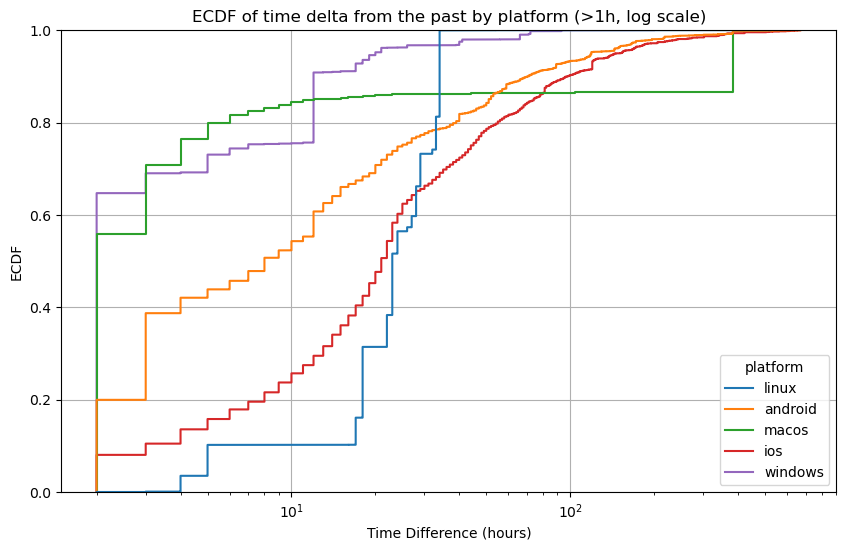

In [446]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=timediff_platform_past_df, x='time_diff', hue='platform', log_scale = True)
plt.title('ECDF of time delta from the past by platform (>1h, log scale)')
plt.xlabel('Time Difference (hours)')
plt.ylabel('ECDF')
plt.grid(True)
plt.savefig("figures/ecdf_timedelta_past_platform.png")
plt.show()

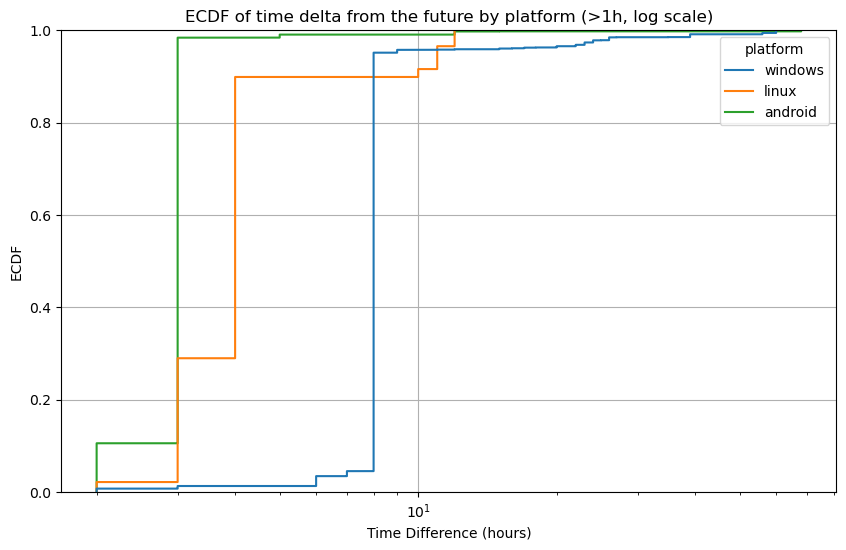

In [450]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=timediff_platform_future_df, x='time_diff', hue='platform', log_scale = True)
plt.title('ECDF of time delta from the future by platform (>1h, log scale)')
plt.xlabel('Time Difference (hours)')
plt.ylabel('ECDF')
plt.grid(True)
plt.savefig("figures/ecdf_timedelta_future_platform.png")
plt.show()